In [1]:
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display
import geopandas as gpd
from geopandas.plotting import plot_polygon_collection

Could not connect to 127.0.0.1: 65150
Traceback (most recent call last):
  File "C:\Users\jthlu\Anaconda3\envs\pamod\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_comm.py", line 507, in start_client
    s.connect((host, port))
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it
Traceback (most recent call last):
  File "C:\Program Files\JetBrains\PyCharm 2021.2\plugins\python\helpers-pro\jupyter_debug\pydev_jupyter_utils.py", line 63, in attach_to_debugger
    debugger.connect(pydev_localhost.get_localhost(), debugger_port)
  File "C:\Users\jthlu\Anaconda3\envs\pamod\lib\site-packages\debugpy\_vendored\pydevd\pydevd.py", line 1380, in connect
    s = start_client(host, port)
  File "C:\Users\jthlu\Anaconda3\envs\pamod\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_comm.py", line 507, in start_client
    s.connect((host, port))
ConnectionRefusedError: [WinError 10061] No connection could

In [2]:
tripdata_file_name = 'fhvhv_tripdata_2019-03.parquet'
shp_file_path = os.path.join('taxi_zones', 'taxi_zones.shp')
taxi_zone_lookup_file_name = 'taxi+_zone_lookup.csv'

Load Taxi Zone to Borough Lookup Dataframe

In [3]:
taxi_zone_lookup = pd.read_csv(taxi_zone_lookup_file_name)
display(taxi_zone_lookup)
zones_to_boroughs = pd.Series(taxi_zone_lookup.Borough.values, index=taxi_zone_lookup.LocationID).to_dict()
boroughs_to_zones = taxi_zone_lookup.groupby('Borough')['LocationID'].apply(lambda x: x.tolist()).to_dict()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


Load Trips Dataframe, add Borough data, cluster non-Manhattan Boroughs

In [7]:
trips = pq.read_table(tripdata_file_name)
trips = trips.to_pandas()
trips['PUBorough'] = trips['PULocationID'].map(zones_to_boroughs)
trips['DOBorough'] = trips['DOLocationID'].map(zones_to_boroughs)
trips['PULocationName'] = trips['PULocationID'].astype(object)
trips['DOLocationName'] = trips['DOLocationID'].astype(object)

non_manhattan_boroughs = set(trips['PUBorough'].unique()).union(set(trips['DOBorough'].unique()))
non_manhattan_boroughs.remove('Manhattan')
for borough in non_manhattan_boroughs:
    trips.loc[trips['PUBorough'] == borough, 'PULocationName'] = borough
    trips.loc[trips['DOBorough'] == borough, 'DOLocationName'] = borough
pd.set_option('display.max_columns', None)

In [19]:
print(trips.columns)
print("There are {} trips in {}.".format(len(trips), tripdata_file_name))
print(trips.dtypes)
locations_keys = trips.PULocationName.unique().tolist()
locations_keys.sort(key=lambda x: (isinstance(x, str), x))
locations = dict(zip(locations_keys, range(len(locations_keys))))
print(locations)

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'PUBorough', 'DOBorough',
       'PULocationName', 'DOLocationName'],
      dtype='object')
There are 23864598 trips in fhvhv_tripdata_2019-03.parquet.
hvfhs_license_num               object
dispatching_base_num            object
originating_base_num            object
request_datetime        datetime64[ns]
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int64
DOLocationID                     int64
trip_miles             

Group by (Origin, Destination, Departure Time at 15 min frequency), drop trips not including Manhattan, and find mean trip distance and trip duration

In [29]:
trips_gb = trips.groupby(['PULocationName', 'DOLocationName', trips.pickup_datetime.dt.floor('15T').dt.time])
trips_agg = trips_gb.size().to_frame(name='counts')
trips_agg = (trips_agg
    .join(trips_gb.agg({'trip_miles': 'mean'}).rename(columns={'trip_miles': 'trip_miles_mean'}))
    .join(trips_gb.agg({'trip_time': 'mean'}).rename(columns={'trip_time': 'trip_time_mean'}))
    .reset_index()
)
trips_agg = trips_agg.drop(trips_agg[(trips_agg['PULocationName'].isin(non_manhattan_boroughs)) & (trips_agg['DOLocationName'].isin(non_manhattan_boroughs))].index)
display(trips_agg)


,PULocationName,DOLocationName,pickup_datetime,counts,trip_miles_mean,trip_time_mean
0,4,4,00:00:00,8,3.988750,695.250000
1,4,4,00:15:00,19,1.185789,322.736842
2,4,4,00:30:00,16,3.804375,819.937500
3,4,4,00:45:00,11,1.118182,411.818182
4,4,4,01:00:00,18,1.723333,405.555556
...,...,...,...,...,...,...
393922,Unknown,249,16:15:00,1,5.400000,1880.000000
393923,Unknown,262,01:30:00,1,3.800000,1021.000000
393924,Unknown,263,17:30:00,1,5.020000,2244.000000
393925,Unknown,263,18:00:00,1,3.160000,970.000000


In [30]:
L = len(locations)
od_matrix = np.zeros((L, L, 24 * 4))
distance_matrix = np.zeros((L, L, 24 * 4))
duration_matrix = np.zeros((L, L, 24 * 4))
count = np.zeros((L, L, 24 * 4))
for i in trips_agg.index:
    idx = locations[trips_agg.loc[i, 'PULocationName']]
    idy = locations[trips_agg.loc[i, 'DOLocationName']]
    time_15 = int(trips_agg.loc[i, 'pickup_datetime'].hour + trips_agg.loc[i, 'pickup_datetime'].minute // 15)
    od_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'counts'])
    distance_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_miles_mean'])
    duration_matrix[idx, idy, time_15] += np.nan_to_num(trips_agg.loc[i, 'trip_time_mean'])
    count[idx, idy, time_15] += 1

count[count == 0] = 1
distance_matrix = np.divide(distance_matrix, count)
duration_matrix = np.divide(duration_matrix, count)

In [31]:
np.save('od_matrix.npy', od_matrix)
np.save('distance_matrix.npy', distance_matrix)
np.save('duration_matrix.npy', duration_matrix)

<AxesSubplot:xlabel='pickup_datetime'>

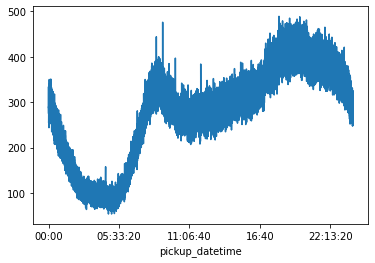

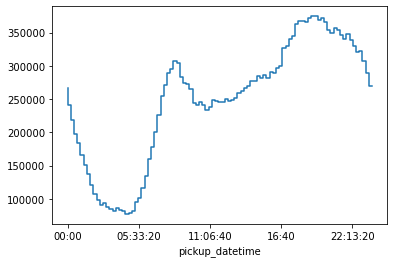

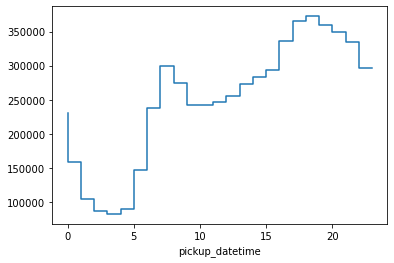

In [35]:
plt.figure()
trips_gb_time = trips.groupby(trips.pickup_datetime.dt.time).size().to_frame(name='counts')
trips_gb_time['counts'].plot(drawstyle='steps')
plt.figure()
trips_gb_time_15 = trips.groupby(trips.pickup_datetime.dt.floor('15T').dt.time).size().to_frame(name='counts')
trips_gb_time_15['counts'].plot(drawstyle='steps')
plt.figure()
trips_gb_time_hour_div_4 = trips.groupby(trips.pickup_datetime.dt.hour).size().to_frame(name='counts')
(trips_gb_time_hour_div_4['counts']/4).plot(drawstyle='steps')

In [43]:
NYC_map = gpd.read_file(shp_file_path)
NYC_map = NYC_map.set_index('LocationID')
NYC_map.index = NYC_map.index.astype(int)
NYC_map = NYC_map.sort_index()
NYC_map['LocationName'] = NYC_map.index.astype(object)
for borough in non_manhattan_boroughs:
    NYC_map.loc[NYC_map['borough'] == borough, 'LocationName'] = borough
    NYC_map.loc[NYC_map['borough'] == borough, 'LocationName'] = borough
display(NYC_map)


,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,LocationName
LocationID,,,,,,,
1,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19...",EWR
2,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",Queens
3,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",Bronx
4,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",4
5,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14...",Staten Island
...,...,...,...,...,...,...,...
259,259,0.126750,0.000395,Woodlawn/Wakefield,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",Bronx
260,260,0.133514,0.000422,Woodside,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",Queens
261,261,0.027120,0.000034,World Trade Center,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19...",261


In [51]:
L_NYC_map = len(NYC_map)
demand_arr = np.zeros(L_NYC_map)
demand_dep = np.zeros(L_NYC_map)
for l_NYC_map_idx, l in enumerate(NYC_map['LocationName']):
    if l in non_manhattan_boroughs:
        l_idx = locations[l]
        print(1, l, l_idx, od_matrix[:, l_idx, :].sum(), len(boroughs_to_zones[l]))
        demand_arr[l_NYC_map_idx] = od_matrix[:, l_idx, :].sum() / len(boroughs_to_zones[l])
        demand_dep[l_NYC_map_idx] = od_matrix[l_idx, :, ].sum() / len(boroughs_to_zones[l])
    elif l in locations:
        l_idx = locations[l]
        print(2, l, l_idx, od_matrix[:, l_idx, :].sum())
        demand_arr[l_NYC_map_idx] = od_matrix[:, l_idx, :].sum()
        demand_dep[l_NYC_map_idx] = od_matrix[l_idx, :, ].sum()
demand_arr = demand_arr / np.sum(demand_arr)
demand_dep = demand_dep / np.sum(demand_dep)
NYC_map['demand_dep'] = demand_dep
NYC_map['demand_arr'] = demand_arr

1 EWR 69 99728.0 1
1 Queens 70 849758.0 69
1 Bronx 67 516341.0 43
2 4 0 88657.0
1 Staten Island 71 11420.0 20
1 Staten Island 71 11420.0 20
1 Queens 70 849758.0 69
1 Queens 70 849758.0 69
1 Queens 70 849758.0 69
1 Queens 70 849758.0 69
1 Brooklyn 68 881400.0 61
2 12 1 4945.0
2 13 2 119919.0
1 Brooklyn 68 881400.0 61
1 Queens 70 849758.0 69
1 Queens 70 849758.0 69
1 Brooklyn 68 881400.0 61
1 Bronx 67 516341.0 43
1 Queens 70 849758.0 69
1 Bronx 67 516341.0 43
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Staten Island 71 11420.0 20
2 24 3 39009.0
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Queens 70 849758.0 69
1 Queens 70 849758.0 69
1 Brooklyn 68 881400.0 61
1 Queens 70 849758.0 69
1 Bronx 67 516341.0 43
1 Bronx 67 516341.0 43
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
1 Queens 70 849758.0 69
1 Brooklyn 68 881400.0 61
1 Brooklyn 68 881400.0 61
2 41 4 159240.0
2 42 5 211079.0
2 43 6 

C:\Users\jthlu\AppData\Local\Temp\ipykernel_11176\894686012.py:9: DeprecationWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  plot_polygon_collection(ax, NYC_map['geometry'], values=NYC_map[column_name], cmap=plt.cm.get_cmap('OrRd'),


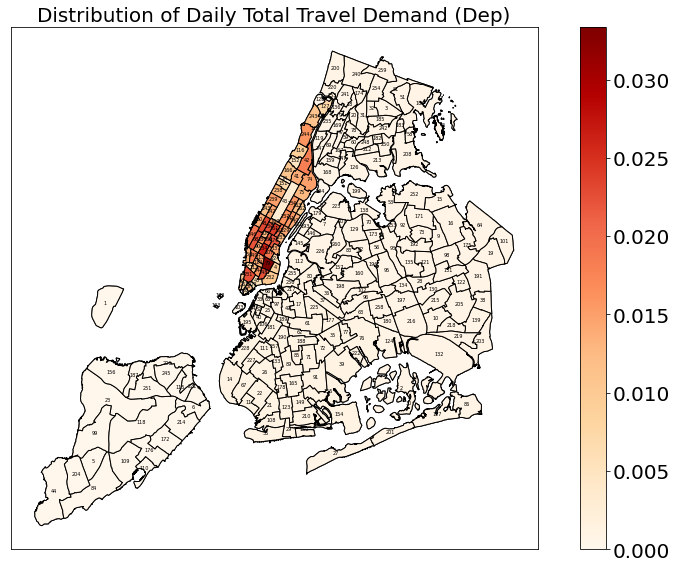

C:\Users\jthlu\AppData\Local\Temp\ipykernel_11176\894686012.py:9: DeprecationWarning: plot_polygon_collection is intended for internal use only, and will be deprecated.
  plot_polygon_collection(ax, NYC_map['geometry'], values=NYC_map[column_name], cmap=plt.cm.get_cmap('OrRd'),


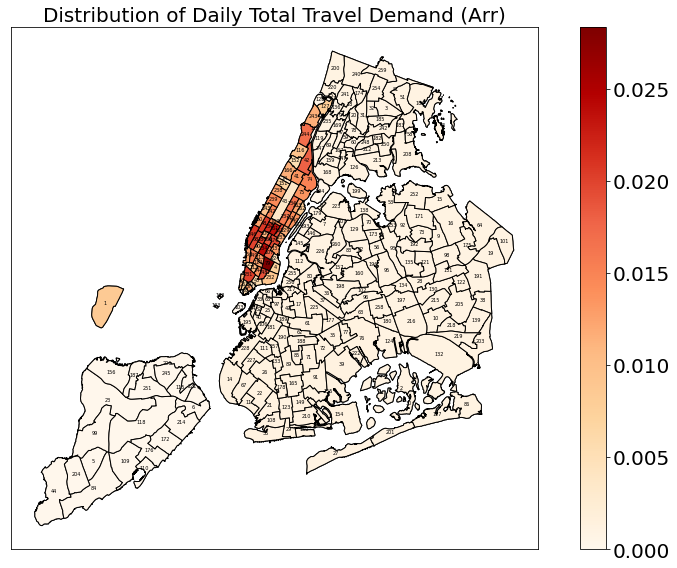

In [47]:
column_names = ['demand_dep', 'demand_arr']
titles = ['Distribution of Daily Total Travel Demand (Dep)',
          'Distribution of Daily Total Travel Demand (Arr)']

for column_name, title in zip(column_names, titles):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax1 = NYC_map.plot(ax=ax, column=column_name, cmap=plt.cm.get_cmap('OrRd'), legend=True, edgecolor='black')
    fig1 = ax1.figure
    plot_polygon_collection(ax, NYC_map['geometry'], values=NYC_map[column_name], cmap=plt.cm.get_cmap('OrRd'),
                            edgecolor='black')
    NYC_map.apply(lambda x: ax.annotate(int(x.name), xy=x.geometry.centroid.coords[0], ha='center', fontsize=5), axis=1)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=20)
    cb_ax = fig1.axes[1]
    cb_ax.tick_params(labelsize=20)
    plt.tight_layout()
    plt.show()


In [55]:

demand_arr[:14]

array([8.48408345e-03, 1.04769288e-03, 1.02154141e-03, 7.54224878e-03,
       4.85762439e-05, 4.85762439e-05, 1.04769288e-03, 1.04769288e-03,
       1.04769288e-03, 1.04769288e-03, 1.22922401e-03, 4.20682182e-04,
       1.02017769e-02, 1.22922401e-03])